<a href="https://colab.research.google.com/github/tomoyukiharada/Kaggle-team/blob/team1/kaggle_taitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
#ライブラリーのインポート
!pip install kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [105]:
#データの読み込み
df = pd.read_csv('train.csv')
#データの確認
print(df.dtypes)
print(len(df['Survived']))
print(df.isnull().sum())

"""
データの総数891に対し、Cabinの欠損値は687個より削除
またチケットも削除する
"""
#データの列を削除
df = df.drop(['Cabin','Ticket','Name'],axis=1)
#enbarkedの欠損値処理
df = df.dropna(subset=['Embarked'])
#年齢の欠損値処理
df['Age'] = df['Age'].fillna(df['Age'].mean())

print(len(df['Survived']))
print(df.isnull().sum())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
891
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
889
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [106]:
#データの変換
df = pd.get_dummies(df,columns=['Sex','Embarked'],drop_first=True)

#AgeとFareのみを標準化
scaler = StandardScaler()
scaler.fit(df[['Age','Fare']])
df[['Age','Fare']] = scaler.transform(df[['Age','Fare']])
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,-0.589620,1,0,-0.500240,True,False,True
1,2,1,1,0.644848,1,0,0.788947,False,False,False
2,3,1,3,-0.281003,0,0,-0.486650,False,False,True
3,4,1,1,0.413385,1,0,0.422861,False,False,True
4,5,0,3,0.413385,0,0,-0.484133,True,False,True


In [107]:
#Sex_maleをSexに名称を変更する
df = df.rename(columns={'Sex_male':'Sex'})

In [84]:
#SurvivedとPclassの関連性
df.groupby('Survived')['Pclass'].value_counts()

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         134
          3         119
          2          87
Name: count, dtype: int64

In [108]:
#SurvivedとSexの関連性
df.groupby('Survived')['Sex'].value_counts()

Survived  Sex  
0         True     468
          False     81
1         False    231
          True     109
Name: count, dtype: int64

In [111]:
#SurvivedとSibSp・Parchの関連性
#あまり同行者数は関係なさそう
df.groupby('Survived')['SibSp'].value_counts()
df.groupby('Survived')['Parch'].value_counts()


Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        231
          1         65
          2         40
          3          3
          5          1
Name: count, dtype: int64

In [139]:
df.groupby('Survived')['Embarked_Q'].value_counts()
#df.groupby('Survived')['Embarked_S'].value_counts()

Survived  Embarked_Q
0         False         502
          True           47
1         False         310
          True           30
Name: count, dtype: int64

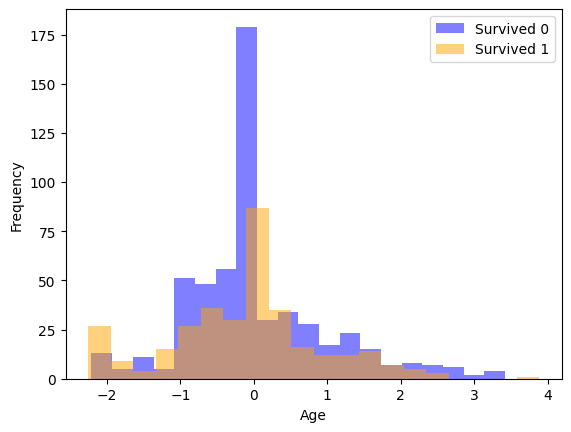

In [126]:
#SurvivedとAgeの関連性
# データの分割
survived_0 = df[df['Survived'] == 0]['Age']
survived_1 = df[df['Survived'] == 1]['Age']

# ヒストグラムの作成
plt.hist(survived_0, bins=20, alpha=0.5, label='Survived 0', color='blue')
plt.hist(survived_1, bins=20, alpha=0.5, label='Survived 1', color='orange')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

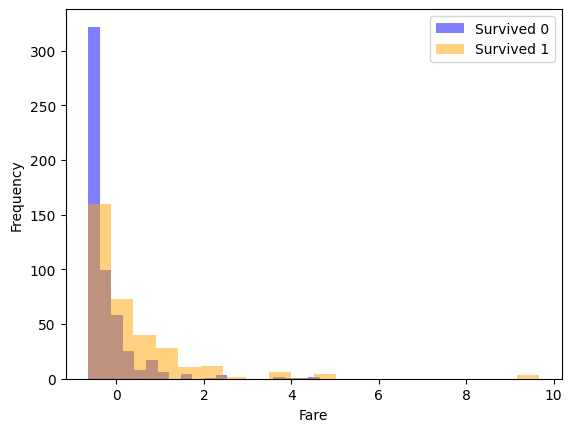

In [131]:
# Fareとの関連性
# データの分割
survived_0 = df[df['Survived'] == 0]['Fare']
survived_1 = df[df['Survived'] == 1]['Fare']

# ヒストグラムの作成
plt.hist(survived_0, bins=20, alpha=0.5, label='Survived 0', color='blue')
plt.hist(survived_1, bins=20, alpha=0.5, label='Survived 1', color='orange')

plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [143]:
#Fareを対数変換
X = df[['Pclass','Sex','Age','Fare']]
y = df[['Survived']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)


In [144]:
#線形判別
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
lda.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7488789237668162

In [145]:
#ロジスティック回帰
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7443946188340808

In [146]:
#最近傍法
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7533632286995515

In [147]:
#ランダムフォレスト
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

<ipython-input-147-dae3fb359a3f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


0.8071748878923767

In [148]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
gbc.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8026905829596412